## Segmenting an chessReD image with SAM

In [11]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch

For now I copied the dataset.py script from the end-to-end thingy because I'm not sure how to use a script in a different directory.
We should, however, make it better in at least the following ways:
 * add functionality to get only the 2k annotated images
 * add option to get the whole dataset and split it into train/val/test separately

In [12]:
from dataset import ChessRecognitionDataset

Update below to the location of the dataroot. We should probably make this easier to use, but for now it'll do

In [13]:
dataroot = '/work/amirkl/DL4CV/end-to-end-chess-recognition/chessReD'
chess_data = ChessRecognitionDataset(dataroot=dataroot, split='train')
annotations = chess_data.annotations
bbox_only = annotations[annotations['bbox'].notna()]
bbox_images = bbox_only['image_id'].unique()

`bbox_images` is a list of all images with bounding box. the 1st image is 2383, and I'll use it for the following parts, but feel free to change it however you see fit, or use multiple images

In [38]:
impath = chess_data.images[chess_data.images['id']==2383]['path'].item()
full_impath = os.path.join(dataroot, impath)

Utility functions for showing SAM input and output

In [31]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


Load the SAM model and predictor.
 * make sure to install the SAM model ([instructions on the git page](https://github.com/facebookresearch/segment-anything#installation)) or it won't work.
 * make the path point to the SAM checkpoint!
 * Running on CUDA and using the default model are recommended.

In [45]:
import sys
sys.path.append('..') # Not sure what this does.
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = os.path.join('/gpfs01/work/amirkl/DL4CV/segment-anything', 'sam_vit_h_4b8939.pth')
model_type = 'vit_h'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

predictor = SamPredictor(sam)

In [46]:
#load image
image = cv2.imread(full_impath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. 
`SamPredictor` remembers this embedding and will use it for subsequent mask prediction.
This means that the following step should be done for *every image*!

In [47]:
predictor.set_image(image)

/home/amirkl/.conda/envs/ML/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831482/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [65]:
bbox_transform = lambda x: [x[0],x[1],x[0]+x[2],x[1]+x[3]] # utility function for transforming box coordinates in (x,y,w,h) to (x1,y1,x2,y2)
bboxes = map(bbox_transform, bbox_only[bbox_only['image_id']==2383]['bbox'])
input_boxes = torch.tensor(list(bboxes), device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, scores, logits = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)
print(f'{masks.shape=}') # sanity check to see that everything is OK

masks.shape=torch.Size([32, 1, 3024, 3024])


# Plot results

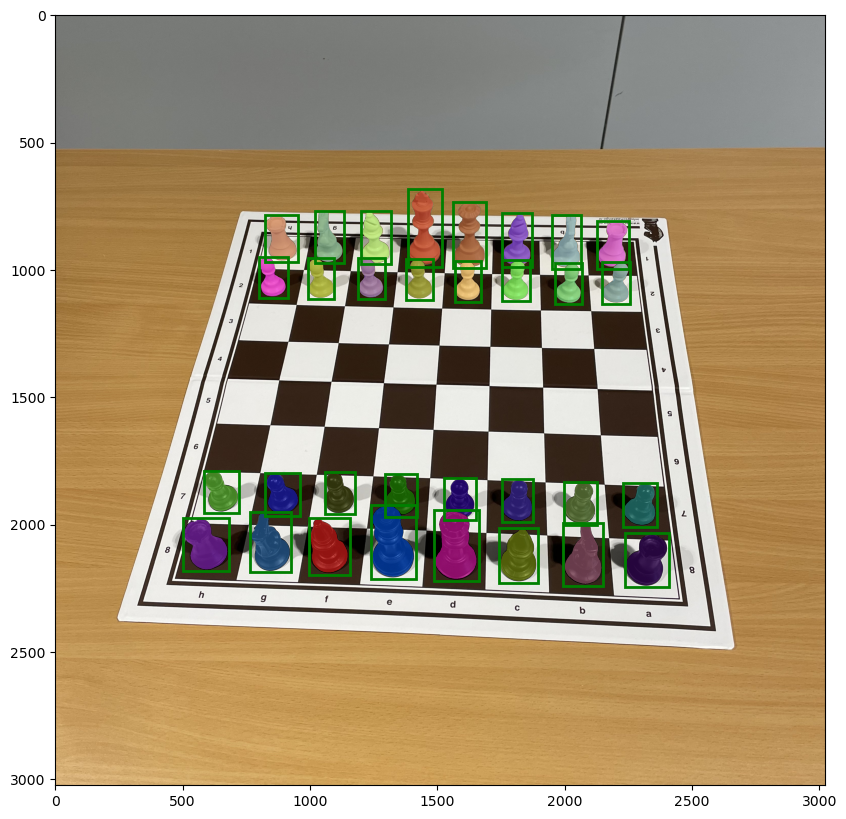

In [66]:
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('on')
plt.show()